## Load and clean the datasets

In [30]:
# import neccessary libarries

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from math import pi
from typing import Iterable, Dict, Tuple, List
import statsmodels.api as sm
from __future__ import annotations
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap
import xgboost as xgb
from xgboost.callback import EarlyStopping
from xgboost import XGBRegressor


In [2]:
#load the data
base_dir = Path('/Users/madalinaciolan/dev/explainable_ai')

#load the energy demand data(load)
load_path = base_dir / 'data' / 'Load' / 'load_history.csv'
load_df = pd.read_csv(load_path)

#load the temperature data
temp_path = base_dir / 'data' / 'Load' / 'temperature_history.csv'
temp_df = pd.read_csv(temp_path)

In [3]:
#fix the index for both dataframes
load_df.index = range(1, len(load_df) + 1)
print(load_df.head())

temp_df.index = range(1, len(temp_df) + 1)
print(temp_df.head())

   zone_id  year  month  day      h1      h2      h3      h4      h5      h6  \
1        1  2004      1    1  16,853  16,450  16,517  16,873  17,064  17,727   
2        1  2004      1    2  14,155  14,038  14,019  14,489  14,920  16,072   
3        1  2004      1    3  14,439  14,272  14,109  14,081  14,775  15,491   
4        1  2004      1    4  11,273  10,415   9,943   9,859   9,881  10,248   
5        1  2004      1    5  10,750  10,321  10,107  10,065  10,419  12,101   

   ...     h15     h16     h17     h18     h19     h20     h21     h22  \
1  ...  13,518  13,138  14,130  16,809  18,150  18,235  17,925  16,904   
2  ...  16,127  15,448  15,839  17,727  18,895  18,650  18,443  17,580   
3  ...  13,507  13,414  13,826  15,825  16,996  16,394  15,406  14,278   
4  ...  14,207  13,614  14,162  16,237  17,430  17,218  16,633  15,238   
5  ...  13,845  14,350  15,501  17,307  18,786  19,089  19,192  18,416   

      h23     h24  
1  16,162  14,750  
2  16,467  15,258  
3  13,315  12,

In [4]:
#check the info and missing values for both dataframes
print(load_df.info())
print(load_df.isna().sum())

print(temp_df.info())
print(temp_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 1 to 33000
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   zone_id  33000 non-null  int64 
 1   year     33000 non-null  int64 
 2   month    33000 non-null  int64 
 3   day      33000 non-null  int64 
 4   h1       31740 non-null  object
 5   h2       31740 non-null  object
 6   h3       31740 non-null  object
 7   h4       31740 non-null  object
 8   h5       31740 non-null  object
 9   h6       31740 non-null  object
 10  h7       31720 non-null  object
 11  h8       31720 non-null  object
 12  h9       31720 non-null  object
 13  h10      31720 non-null  object
 14  h11      31720 non-null  object
 15  h12      31720 non-null  object
 16  h13      31720 non-null  object
 17  h14      31720 non-null  object
 18  h15      31720 non-null  object
 19  h16      31720 non-null  object
 20  h17      31720 non-null  object
 21  h18      31720 non-null  object
 22

In [5]:
# ---- Clean the load dataframe ----   
load_df_clean = load_df.copy()
cols = [f"h{i}" for i in range(1, 25)]
for col in cols:
    load_df_clean[col] = load_df_clean[col].str.replace(",", "").astype(float)

print(load_df_clean.dtypes)
print(load_df_clean.isna().sum())

zone_id      int64
year         int64
month        int64
day          int64
h1         float64
h2         float64
h3         float64
h4         float64
h5         float64
h6         float64
h7         float64
h8         float64
h9         float64
h10        float64
h11        float64
h12        float64
h13        float64
h14        float64
h15        float64
h16        float64
h17        float64
h18        float64
h19        float64
h20        float64
h21        float64
h22        float64
h23        float64
h24        float64
dtype: object
zone_id       0
year          0
month         0
day           0
h1         1260
h2         1260
h3         1260
h4         1260
h5         1260
h6         1260
h7         1280
h8         1280
h9         1280
h10        1280
h11        1280
h12        1280
h13        1280
h14        1280
h15        1280
h16        1280
h17        1280
h18        1280
h19        1280
h20        1280
h21        1280
h22        1280
h23        1280
h24        1280
dtype:

## Fill in missing values

In [6]:
# --- Fill NaNs in load_df_clean using interpolation before/after ---
# 1) Horizontal interpolation within each day across h1..h24
#    (fills gaps inside a day's 24 hours using surrounding hours)
load_df_clean[cols] = load_df_clean[cols].interpolate(method='linear', axis=1, limit_direction='both')

# 2) Vertical interpolation across days for each hour h1..h24
#    (fills gaps across days using surrounding days for each hour)
load_df_clean[cols] = load_df_clean[cols].interpolate(method='linear',  axis=0, limit_direction='both')

# check if all NaNs in the load data frame have been filled
print("\nRemaining NaNs per column after interpolation: ", load_df_clean[cols].isna().sum())


Remaining NaNs per column after interpolation:  h1     0
h2     0
h3     0
h4     0
h5     0
h6     0
h7     0
h8     0
h9     0
h10    0
h11    0
h12    0
h13    0
h14    0
h15    0
h16    0
h17    0
h18    0
h19    0
h20    0
h21    0
h22    0
h23    0
h24    0
dtype: int64


In [7]:
# ---- Clean the temperature dataframe ----  
print(load_df_clean.dtypes) #no need to change types, they are already integers and floats
print(temp_df.isna().sum()) #NaNs only in temperature colums h7 -> h24
temp_df_clean = temp_df.copy()

zone_id      int64
year         int64
month        int64
day          int64
h1         float64
h2         float64
h3         float64
h4         float64
h5         float64
h6         float64
h7         float64
h8         float64
h9         float64
h10        float64
h11        float64
h12        float64
h13        float64
h14        float64
h15        float64
h16        float64
h17        float64
h18        float64
h19        float64
h20        float64
h21        float64
h22        float64
h23        float64
h24        float64
dtype: object
station_id     0
year           0
month          0
day            0
h1             0
h2             0
h3             0
h4             0
h5             0
h6             0
h7            11
h8            11
h9            11
h10           11
h11           11
h12           11
h13           11
h14           11
h15           11
h16           11
h17           11
h18           11
h19           11
h20           11
h21           11
h22           11
h23         

In [8]:
# --- Fill NaNs in load_df_clean using interpolation before/after ---
#  Vertical interpolation across days for each hour h7..h24
#    (fills gaps across days using surrounding days for each hour)
cols_temp = [f"h{i}" for i in range(7, 25)]
for col in cols_temp:
    temp_df_clean[col] = temp_df_clean[col].interpolate(method='linear', axis=0, limit_direction='both')    

In [9]:
#check if all NaNs in the temperature data frame have been filled
print("\nRemaining NaNs per column after interpolation: ", temp_df_clean.isna().sum()) 

print(load_df_clean.head())


Remaining NaNs per column after interpolation:  station_id    0
year          0
month         0
day           0
h1            0
h2            0
h3            0
h4            0
h5            0
h6            0
h7            0
h8            0
h9            0
h10           0
h11           0
h12           0
h13           0
h14           0
h15           0
h16           0
h17           0
h18           0
h19           0
h20           0
h21           0
h22           0
h23           0
h24           0
dtype: int64
   zone_id  year  month  day       h1       h2       h3       h4       h5  \
1        1  2004      1    1  16853.0  16450.0  16517.0  16873.0  17064.0   
2        1  2004      1    2  14155.0  14038.0  14019.0  14489.0  14920.0   
3        1  2004      1    3  14439.0  14272.0  14109.0  14081.0  14775.0   
4        1  2004      1    4  11273.0  10415.0   9943.0   9859.0   9881.0   
5        1  2004      1    5  10750.0  10321.0  10107.0  10065.0  10419.0   

        h6  ...      h15   

## Reshape both data frames from wide to long format

In [10]:
# ----Reshaping the load dataframe from wide to long format ----

# Melt the dataframe to have a long format with columns: year, month, day, hour, load
hours_cols = [f"h{i}" for i in range(1, 25)]
load_long = load_df_clean.melt(
    id_vars=["zone_id", "year", "month", "day"],
    value_vars=hours_cols,
    var_name="hour",
    value_name="load",
)

# Convert hour column to numeric hour
load_long['hour'] = load_long['hour'].str.extract('h(\d+)').astype(int)

# Create a datetime column
load_long['date_time'] = pd.to_datetime(load_long[['year', 'month', 'day']]) + pd.to_timedelta(load_long['hour'] - 1, unit='h')

#Keep only relevant columns and sort by date
load_long = load_long[['zone_id','date_time', 'load']].sort_values(['zone_id', 'date_time']).reset_index(drop=True)
print(load_long.head())



   zone_id           date_time     load
0        1 2004-01-01 00:00:00  16853.0
1        1 2004-01-01 01:00:00  16450.0
2        1 2004-01-01 02:00:00  16517.0
3        1 2004-01-01 03:00:00  16873.0
4        1 2004-01-01 04:00:00  17064.0


In [11]:
print(temp_df_clean.head())

# ----Reshaping the temperature dataframe from wide to long format ----

# Melt the dataframe to have a long format with columns: year, month, day, hour, temperature
temp_hour_cols = [f"h{i}" for i in range(1, 25)]
temp_long = temp_df_clean.melt(
    id_vars=["station_id", "year", "month", "day"],
    value_vars=temp_hour_cols,
    var_name="hour",
    value_name="temperature",
)

# Convert hour column to numeric hour
temp_long['hour'] = temp_long['hour'].str.extract('h(\d+)').astype(int)

# Create a datetime column
temp_long['date_time'] = pd.to_datetime(temp_long[['year', 'month', 'day']]) + pd.to_timedelta(temp_long['hour'] - 1, unit='h')

#Keep only relevant columns and sort by date
#temp_long = temp_long[['station_id','date_time', 'temperature']].sort_values(by='date_time').reset_index(drop=True)
#print(temp_long.head())

# Pivot so each station is one column
temp_wide = temp_long.pivot(index='date_time', columns='station_id', values='temperature')
temp_wide.columns = [f"station_{col}" for col in temp_wide.columns]

print(temp_long.head())

   station_id  year  month  day  h1  h2  h3  h4  h5  h6  ...   h15   h16  \
1           1  2004      1    1  46  46  45  41  39  35  ...  55.0  55.0   
2           1  2004      1    2  43  44  46  46  47  47  ...  54.0  56.0   
3           1  2004      1    3  45  46  46  44  43  46  ...  69.0  68.0   
4           1  2004      1    4  63  62  62  62  60  60  ...  71.0  72.0   
5           1  2004      1    5  64  63  65  64  64  64  ...  66.0  66.0   

    h17   h18   h19   h20   h21   h22   h23   h24  
1  52.0  46.0  40.0  40.0  39.0  38.0  40.0  41.0  
2  57.0  53.0  50.0  47.0  46.0  45.0  45.0  45.0  
3  68.0  65.0  64.0  63.0  62.0  63.0  63.0  62.0  
4  71.0  68.0  67.0  67.0  65.0  64.0  65.0  64.0  
5  66.0  66.0  63.0  54.0  52.0  49.0  47.0  47.0  

[5 rows x 28 columns]
   station_id  year  month  day  hour  temperature  date_time
0           1  2004      1    1     1         46.0 2004-01-01
1           1  2004      1    2     1         43.0 2004-01-02
2           1  2004   

## Merge the dataframes 
### Two options: attach all of the stations' temperature to each load record or infer a map of correlations.
### Have chosen the first option as it is recommended for modeling. I have merged the load data with all stations' temperatures so each load observation has temp_station_1, ... , temp_station_11 as features. This avoids the need to have a  zone <-> station map.

In [12]:
# --- Merge: attach all stations' temperatures to each load record ---
merged_all = load_long.merge(temp_wide.reset_index(), on='date_time', how='left')
print(merged_all)

        zone_id           date_time     load  station_1  station_2  station_3  \
0             1 2004-01-01 00:00:00  16853.0       46.0       38.0       44.0   
1             1 2004-01-01 01:00:00  16450.0       46.0       36.0       42.0   
2             1 2004-01-01 02:00:00  16517.0       45.0       35.0       40.0   
3             1 2004-01-01 03:00:00  16873.0       41.0       30.0       36.0   
4             1 2004-01-01 04:00:00  17064.0       39.0       30.0       34.0   
...         ...                 ...      ...        ...        ...        ...   
791995       20 2008-07-07 19:00:00  74728.0        NaN        NaN        NaN   
791996       20 2008-07-07 20:00:00  74728.0        NaN        NaN        NaN   
791997       20 2008-07-07 21:00:00  74728.0        NaN        NaN        NaN   
791998       20 2008-07-07 22:00:00  74728.0        NaN        NaN        NaN   
791999       20 2008-07-07 23:00:00  74728.0        NaN        NaN        NaN   

        station_4  station_

In [13]:
merged_all.isnull().sum() #check for missing values after the merge

zone_id          0
date_time        0
load             0
station_1     3360
station_2     3360
station_3     3360
station_4     3360
station_5     3360
station_6     3360
station_7     3360
station_8     3360
station_9     3360
station_10    3360
station_11    3360
dtype: int64

In [14]:
merged_all_cleaned = merged_all.dropna().reset_index(drop=True) #drop rows with any NaNs and reset index
print(merged_all_cleaned)

        zone_id           date_time     load  station_1  station_2  station_3  \
0             1 2004-01-01 00:00:00  16853.0       46.0       38.0       44.0   
1             1 2004-01-01 01:00:00  16450.0       46.0       36.0       42.0   
2             1 2004-01-01 02:00:00  16517.0       45.0       35.0       40.0   
3             1 2004-01-01 03:00:00  16873.0       41.0       30.0       36.0   
4             1 2004-01-01 04:00:00  17064.0       39.0       30.0       34.0   
...         ...                 ...      ...        ...        ...        ...   
788635       20 2008-06-30 19:00:00  74728.0       67.0       54.0       63.5   
788636       20 2008-06-30 20:00:00  74728.0       65.5       51.0       61.5   
788637       20 2008-06-30 21:00:00  74728.0       64.5       48.5       58.0   
788638       20 2008-06-30 22:00:00  74728.0       61.0       48.5       59.0   
788639       20 2008-06-30 23:00:00  74728.0       60.0       48.5       59.0   

        station_4  station_

In [15]:
merged_all_cleaned.isnull().sum()

zone_id       0
date_time     0
load          0
station_1     0
station_2     0
station_3     0
station_4     0
station_5     0
station_6     0
station_7     0
station_8     0
station_9     0
station_10    0
station_11    0
dtype: int64

## Build time features:
####    •	cyclical encodings (hour/dow/doy)
####	•	weekend + US holiday flags (holiday, day-before, day-after)
####	•	approximate sunrise/sunset + daylight flags (no lat/lon as the geografical zone is unknown) 
####	•	Heating Degree Days(HDD) / Cooling Degree Days (CDD) from all temp_station_* columns (auto-detects temps) with a threshold of 18 °C

In [16]:
holidays = pd.read_csv(base_dir / 'data' / 'Load' / 'Holiday_List.csv')
print(type(holidays))
print(holidays.head())

<class 'pandas.core.frame.DataFrame'>
                            Unnamed: 0                 2004  \
0                       New Year's Day  Thursday, January 1   
1  Birthday of Martin Luther King, Jr.   Monday, January 19   
2                Washington's Birthday  Monday, February 16   
3                         Memorial Day       Monday, May 31   
4                     Independence Day       Monday, July 5   

                        2005                 2006                 2007  \
0  Friday, December 31, 2004    Monday, January 2    Monday, January 1   
1         Monday, January 17   Monday, January 16   Monday, January 15   
2        Monday, February 21  Monday, February 20  Monday, February 19   
3             Monday, May 30       Monday, May 29       Monday, May 28   
4             Monday, July 4      Tuesday, July 4    Wednesday, July 4   

                  2008  
0   Tuesday, January 1  
1   Monday, January 21  
2  Monday, February 18  
3       Monday, May 26  
4       Frida

In [17]:

# --- Robust: convert wide holiday matrix (rows=holiday names, cols=years) into tidy 'date' list
def _normalize_holiday_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handles cases where the holiday name is in the index or in the first column,
    and drops any non-year columns like 'Unnamed: 0' before parsing.
    """
    # If holiday names are the index, promote to a column named 'holiday'
    if df.index.name is None or df.index.equals(pd.RangeIndex(len(df))):
        # Try to detect when the first column is the holiday name
        first_col = df.columns[0]
        # If the first column looks like year (numeric), then names must be in the index -> add from index
        if pd.to_numeric(pd.Index(df.columns), errors="coerce").notna().sum() > 0 and not pd.api.types.is_object_dtype(df[first_col]):
            df2 = df.rename_axis("holiday").reset_index()
        else:
            # Assume first column holds holiday names
            df2 = df.copy()
            if first_col.lower() != "holiday":
                df2 = df2.rename(columns={first_col: "holiday"})
    else:
        df2 = df.rename_axis("holiday").reset_index()

    # Melt to long format
    long = df2.melt(id_vars=["holiday"], var_name="year", value_name="raw")

    # Keep only rows where 'year' is numeric (drop 'Unnamed: 0' etc.)
    long["year_num"] = pd.to_numeric(long["year"], errors="coerce")
    long = long[long["year_num"].notna()].copy()

    # Clean raw strings; drop blanks
    long["raw"] = long["raw"].astype(str).str.strip()
    long = long[~long["raw"].isin(["", "nan", "NaN"])]

    # Parse each cell: if text already contains a 4-digit year, parse as-is; else append the numeric year
    def _parse_row(row):
        txt = row["raw"].strip().strip('"').strip("'")
        yr  = int(row["year_num"])
        txt = re.sub(r"\s+,", ",", txt)          # fix stray spaces before commas
        txt = re.sub(r"\s{2,}", " ", txt)        # collapse multiple spaces
        if re.search(r"\b\d{4}\b", txt):
            dt = pd.to_datetime(txt, errors="coerce")
        else:
            dt = pd.to_datetime(f"{txt}, {yr}", errors="coerce")
        return dt

    long["date"] = long.apply(_parse_row, axis=1)
    dates = (long["date"]
             .dropna()
             .dt.normalize()
             .drop_duplicates()
             .sort_values())
    return pd.DataFrame({"date": dates})


def make_features(
    df: pd.DataFrame,
    holidays,                     # can be a path or a wide-format DataFrame
    *,
    date_col: str = "date_time",
    temp_prefix: str = "temp_station_",
    base_c: float = 18.0,       # base temperature for HDD/CDD calculations (°C)
    doy_period: int = 366,      # leap-year friendly
    sr_mean: float = 6.5,       # 06:30 average sunrise time
    sr_amp: float = 1.5,        # +/- 1.5 hours amplitude (earliest sunrise ~05:00, latest ~08:00) 
    ss_mean: float = 18.5,      # 18:30 average sunset time
    ss_amp: float = 2.0         # +/- 2.0 hours amplitude (earliest sunset ~17:30, latest ~20:30)
) -> pd.DataFrame:
    """
    Adds:
      • cyclical encodings (hour/dow/doy)
      • weekend + holiday flags
      • approximate sunrise/sunset + daylight
      • HDD/CDD from all temp_station_* columns (°C)

    Parameters:
    - df: Input dataframe with a datetime column and temperature columns
    - holidays: DataFrame containing US holidays with a 'date' column
    - date_col: Name of the datetime column in df
    - temp_prefix: Prefix for temperature columns to consider for HDD/CDD calculations
    - base_c: Base temperature in Celsius for HDD/CDD calculations
    - doy_period: Period for cyclical encoding of day of year (366 to include leap year)
    - sr_mean, sr_amp: Mean and amplitude for sunrise time approximation
    - ss_mean, ss_amp: Mean and amplitude for sunset time approximation
    """
    out = df.copy()

    # ---- timestamp
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    if out[date_col].isna().any():
        raise ValueError(f"{date_col} contains NaT after parsing.")
    dt = out[date_col]

    out["hour"] = dt.dt.hour
    out["dow"] = dt.dt.dayofweek
    out["is_weekend"] = (out["dow"] >= 5).astype(int)
    doy = dt.dt.dayofyear.astype(int)

    # ---- cyclical encodings
    out["hour_sin"] = np.sin(2 * pi * out["hour"] / 24)
    out["hour_cos"] = np.cos(2 * pi * out["hour"] / 24)
    out["dow_sin"]  = np.sin(2 * pi * out["dow"] / 7)
    out["dow_cos"]  = np.cos(2 * pi * out["dow"] / 7)
    out["doy_sin"]  = np.sin(2 * pi * doy / doy_period)
    out["doy_cos"]  = np.cos(2 * pi * doy / doy_period)

    # ---- holidays (accept path or DataFrame)
    if isinstance(holidays, (str, os.PathLike)):
        holidays_df = pd.read_csv(holidays)
    elif isinstance(holidays, pd.DataFrame):
        holidays_df = holidays.copy()
    else:
        raise ValueError("holidays must be a CSV path or a DataFrame")

    # normalize the wide holiday matrix into a single 'date' column
    holidays_norm = _normalize_holiday_matrix(holidays_df)
    hol_days = set(holidays_norm["date"].unique())
    cal_day = dt.dt.normalize()

    out["is_holiday"]            = cal_day.isin(hol_days).astype(int)
    out["is_day_before_holiday"] = cal_day.isin({d - pd.Timedelta(days=1) for d in hol_days}).astype(int)
    out["is_day_after_holiday"]  = cal_day.isin({d + pd.Timedelta(days=1) for d in hol_days}).astype(int)

    # sunrise/sunset-like approximation
    sunrise_hour = sr_mean - sr_amp * np.cos(2 * pi * doy / doy_period)
    sunset_hour  = ss_mean + ss_amp * np.cos(2 * pi * doy / doy_period)

    out["sunrise_hour_approx"]   = sunrise_hour
    out["sunset_hour_approx"]    = sunset_hour
    out["daylight_hours_approx"] = sunset_hour - sunrise_hour
    out["is_daylight_approx"]    = ((out["hour"] >= sunrise_hour.astype(int)) &
                                    (out["hour"] <  sunset_hour.astype(int))).astype(int)
    out["daylight_proxy"]        = np.sin(2 * pi * doy / doy_period)

    # ---- HDD/CDD from temperature columns (°C)
    temp_cols = [c for c in out.columns if c.startswith(temp_prefix)]
    if not temp_cols:
        # fallback: any column containing 'temp'
        temp_cols = [c for c in out.columns if re.search(r"temp", c, re.IGNORECASE)]
    if temp_cols:
        out["temp_mean"] = out[temp_cols].mean(axis=1)
        out["HDD"] = (base_c - out["temp_mean"]).clip(lower=0)
        out["CDD"] = (out["temp_mean"] - base_c).clip(lower=0)

    return out

features_df = make_features(merged_all_cleaned, holidays, temp_prefix='station_')
print(features_df.head())     

   zone_id           date_time     load  station_1  station_2  station_3  \
0        1 2004-01-01 00:00:00  16853.0       46.0       38.0       44.0   
1        1 2004-01-01 01:00:00  16450.0       46.0       36.0       42.0   
2        1 2004-01-01 02:00:00  16517.0       45.0       35.0       40.0   
3        1 2004-01-01 03:00:00  16873.0       41.0       30.0       36.0   
4        1 2004-01-01 04:00:00  17064.0       39.0       30.0       34.0   

   station_4  station_5  station_6  station_7  ...  is_day_before_holiday  \
0       45.0       42.0       44.0       45.0  ...                      0   
1       43.0       42.0       43.0       44.0  ...                      0   
2       41.0       40.0       42.0       41.0  ...                      0   
3       37.0       39.0       38.0       40.0  ...                      0   
4       33.0       40.0       38.0       35.0  ...                      0   

   is_day_after_holiday  sunrise_hour_approx  sunset_hour_approx  \
0           

## Create lag/rolling features
#### The lag/rolling features are created only for exogenous variables -columns that are not the target(target is load) and are not identifiers (zone_id, date_time)- used later in an ARIMAX model (ARIMA with exogenous regressors). 
##### Examples: temperature (station_1,..., station_11, temp_mean), derived weather indicators (HDD, CDD), holidays(is_day_before_holiday, is_day_after_holiday), sunlight (sunrise_hour_approx, sunset_hour_approx, daylight_hours_approx, is_daylight_approx, daylight_proxy)
##### Electricity load is strongly influenced by weather and holidays.

In [18]:

def add_exogenous_lags_for_features_df(
    df: pd.DataFrame,
    *,
    group_col: str = "zone_id",
    date_col: str = "date_time",
    # temperature-like columns
    temp_prefix: str = "station_",                              # station_1..station_11
    include_extra_temp_cols: Iterable[str] = ("temp_mean", "HDD", "CDD"),
    temp_lags: tuple[int, ...] = (1, 3, 6, 24, 48, 168),        # lags in hours
    temp_rolls: tuple[int, ...] = (6, 24, 168),                 # rolling windows in hours
    # holiday columns present in features_df
    holiday_cols: Iterable[str] = ("is_day_before_holiday", "is_day_after_holiday"),
    holiday_lags: tuple[int, ...] = (),                         # usually not needed
    holiday_leads: tuple[int, ...] = (24, 168)                  # usually only 1-day lead
) -> pd.DataFrame:
    """
    Adds lagged and rolling-window features for exogenous variables (non-target, non-ID columns)
    to be used in an ARIMAX model (ARIMA with exogenous regressors).

    Parameters:
    - df: Input dataframe with a datetime column and temperature columns
    - group_col: Column to group by (e.g., zone_id) for separate lagging per group
    - date_col: Name of the datetime column in df
    - temp_prefix: Prefix for temperature columns to consider for lagging/rolling
    - include_extra_temp_cols: Additional temperature-like columns to include (e.g., temp_mean, HDD, CDD)
    - temp_lags: Tuple of integer lags (in hours) to create for temperature-like columns
    - temp_rolls: Tuple of integer rolling window sizes (in hours) to create for temperature-like columns
    - holidays_cols: List of holiday-related binary columns to consider for lagging/leading
    - holiday_lags: Tuple of integer lags (in hours) to create for holiday columns
    - holiday_leads: Tuple of integer leads (in hours) to create for holiday columns

    Returns:
    - DataFrame with original and new lagged/rolling features
    """
    out = df.copy()
    out = out.sort_values([group_col, date_col], kind="mergesort")
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")

    # ---- collect temperature columns
    temp_cols = [c for c in out.columns if c.startswith(temp_prefix)]
    for c in include_extra_temp_cols:
        if c in out.columns:
            temp_cols.append(c)
    temp_cols = list(dict.fromkeys(temp_cols))  # de-duplicate while keeping order

    if not temp_cols:
        raise ValueError("No temperature columns found (station_* / temp_mean / HDD / CDD).")

    # ---- group per zone
    g = out.groupby(group_col, group_keys=False)

    # ---- temperature lags
    for L in temp_lags:
        for c in temp_cols:
            out[f"{c}_lag{L}"] = g[c].shift(L)

    # ---- temperature rolling means
    for W in temp_rolls:
        for c in temp_cols:
            out[f"{c}_roll{W}"] = g[c].transform(lambda s: s.rolling(W, min_periods=1).mean())

    # ---- holiday lags/leads
    hol_cols_present = [h for h in holiday_cols if h in out.columns]

    for L in holiday_lags:
        for h in hol_cols_present:
            out[f"{h}_lag{L}"] = g[h].shift(L)

    for H in holiday_leads:
        for h in hol_cols_present:
            out[f"{h}_lead{H}"] = g[h].shift(-H)

    return out

In [19]:
features_with_lags = add_exogenous_lags_for_features_df(
    features_df,                    # my DataFrame
    group_col="zone_id",
    date_col="date_time",
    temp_prefix="station_",         # station_1..station_11
    include_extra_temp_cols=("temp_mean", "HDD", "CDD"),
    temp_lags=(1, 3, 6, 24, 48, 168),
    temp_rolls=(6, 24, 168),
    holiday_cols=("is_day_before_holiday", "is_day_after_holiday"),
    holiday_lags=(),                # usually leave empty
    holiday_leads=(24, 168)         # holidays are known → safe leads
)

/var/folders/y6/w4x154ys7zd4n1hm8b7sn2hh0000gp/T/ipykernel_63859/1059531882.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{c}_roll{W}"] = g[c].transform(lambda s: s.rolling(W, min_periods=1).mean())
/var/folders/y6/w4x154ys7zd4n1hm8b7sn2hh0000gp/T/ipykernel_63859/1059531882.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{c}_roll{W}"] = g[c].transform(lambda s: s.rolling(W, min_periods=1).mean())
/var/folders/y6/w4x154ys7zd4n1hm8b7sn2hh0000gp/T/ipykernel_63859/1059531882.py:60: PerformanceWarning: DataFra

### Check again for data quality: no missing timestamps and ensure consistent hourly intervals. 
#### Each zone_id must have a continous, clean and hourly time series with aligned features.

In [20]:
# Sort and check continuity per zone_id
features_with_lags = features_with_lags.sort_values(["zone_id", "date_time"]).reset_index(drop=True)

print(features_with_lags.head())

# Check time step gaps per zone_id
gaps = (
    features_with_lags.groupby("zone_id")["date_time"]          #handle multiple zones separately
    .diff()                                                     #computes the time difference between consecutive timestamps within each zone
    .dropna()                                                   #removes the first row in each group(since it has no previous timestamp to diff against)
    .value_counts()                                             #counts how many times each time gap occurs across the dataset
)
print(gaps.head())
print(gaps.isna().sum())


   zone_id           date_time     load  station_1  station_2  station_3  \
0        1 2004-01-01 00:00:00  16853.0       46.0       38.0       44.0   
1        1 2004-01-01 01:00:00  16450.0       46.0       36.0       42.0   
2        1 2004-01-01 02:00:00  16517.0       45.0       35.0       40.0   
3        1 2004-01-01 03:00:00  16873.0       41.0       30.0       36.0   
4        1 2004-01-01 04:00:00  17064.0       39.0       30.0       34.0   

   station_4  station_5  station_6  station_7  ...  station_9_roll168  \
0       45.0       42.0       44.0       45.0  ...          41.000000   
1       43.0       42.0       43.0       44.0  ...          40.000000   
2       41.0       40.0       42.0       41.0  ...          38.666667   
3       37.0       39.0       38.0       40.0  ...          37.750000   
4       33.0       40.0       38.0       35.0  ...          36.800000   

   station_10_roll168  station_11_roll168  temp_mean_roll168  HDD_roll168  \
0           42.000000      

In [21]:
# Check for missing values 
features_with_lags.isna().sum().sort_values(ascending=False).head(10)


is_day_after_holiday_lead168    3360
station_9_lag168                3360
station_1_lag168                3360
station_2_lag168                3360
station_3_lag168                3360
station_4_lag168                3360
station_5_lag168                3360
station_6_lag168                3360
station_8_lag168                3360
station_7_lag168                3360
dtype: int64

In [22]:
"""
Lagged and lead features introduced some NaNs at the start/end of each zone_id group:
- when shifting the time series backward by 168 hrs(7 days), the first 168 rows of each zone_id cannot be filled in and will have NaNs for those lagged features
- when shifting the time series forward by 168 hrs(7 days), the last 168 rows of each zone_id have "no future data" to shift into them.

So:
    - for station_1_lag168, station_2_lag168, ..., station_11_lag168, the first 168 timestamps for each zone_id will be NaN.
    - for is_day_before_holiday_lead168, is_day_after_holiday_lead168, the last 168 timestamps for each zone_id will be NaN.

"""

# Missing values percentage is 0.02% therefore we can drop the rows with NaN
features_with_lags = features_with_lags.dropna().reset_index(drop=True)
print((features_with_lags).isna().sum().sort_values(ascending=False).head(10))


zone_id             0
CDD_lag48           0
station_2_lag168    0
station_3_lag168    0
station_4_lag168    0
station_5_lag168    0
station_6_lag168    0
station_7_lag168    0
station_8_lag168    0
station_9_lag168    0
dtype: int64


In [23]:
# Check for infinite values
np.isinf(features_with_lags).sum()

zone_id                          0
date_time                        0
load                             0
station_1                        0
station_2                        0
                                ..
CDD_roll168                      0
is_day_before_holiday_lead24     0
is_day_after_holiday_lead24      0
is_day_before_holiday_lead168    0
is_day_after_holiday_lead168     0
Length: 164, dtype: int64

In [24]:
print(features_with_lags.head())

   zone_id           date_time     load  station_1  station_2  station_3  \
0        1 2004-01-08 00:00:00  25104.0       29.0       22.0       21.0   
1        1 2004-01-08 01:00:00  25122.0       26.0       22.0       20.0   
2        1 2004-01-08 02:00:00  25464.0       24.0       21.0       20.0   
3        1 2004-01-08 03:00:00  25715.0       22.0       21.0       19.0   
4        1 2004-01-08 04:00:00  26219.0       22.0       22.0       18.0   

   station_4  station_5  station_6  station_7  ...  station_9_roll168  \
0       25.0       23.0       25.0       21.0  ...          44.654762   
1       26.0       24.0       26.0       21.0  ...          44.565476   
2       25.0       23.0       25.0       20.0  ...          44.482143   
3       22.0       24.0       26.0       20.0  ...          44.398810   
4       20.0       24.0       27.0       21.0  ...          44.339286   

   station_10_roll168  station_11_roll168  temp_mean_roll168  HDD_roll168  \
0           48.976190      

#### In terms of explainability techniques, ARIMA is already a "white box" so there is no need to apply SHAP and LIME, however if we want to locally explain a prediction, that would need to be computed that manually.
#### ARIMA does not need to have manually lagged features and assumes only one variable, therefore for our timeseries with multiple variables, we would need to use SARIMAX which is a seasonal ARIMA with exogenous variables.
#### In terms of explainability techniques, in a SARIMAX model, the coeficients themselves are the explanations, where in a XGBoost model (and other ML models), SHAP or LIME can explain which features influence each prediction, whether they increased or decreased the forecast and how strongly the features contributed to the forecast.
#### The goal is forecast accuracy and feature interpretability, therefore the strategy is to start with a SARIMAX model to get baseline interpretability and understand structure. Later on, we will move to XGBoost for better accuracy and use SHAP for interpretability.

In [ ]:
# ---- SARIMAX model fitting and evaluation ----
# Running SARIMAX on all zones is too slow, therefore we will run it on a single zone)

# Quick test on a single zone
# 1) Filter one zone and enforce hourly frequency
zone = 1
df_zone = (features_with_lags
           .loc[features_with_lags["zone_id"] == zone]
           .sort_values("date_time")
           .set_index("date_time")
           .asfreq("h"))
# 2) Select target and exogenous columns
cols_exog = ["temp_mean", "HDD", "CDD", "is_holiday"]  
missing_cols = [c for c in cols_exog if c not in df_zone.columns]
if missing_cols:
    raise KeyError(f"Exogenous columns missing: {missing_cols}")

y = df_zone["load"]
X = df_zone[cols_exog].apply(pd.to_numeric, errors="coerce")
if "is_holiday" in X:
    X["is_holiday"] = X["is_holiday"].fillna(0).astype(int)

# 3) Clean rows: no NaN or inf values in y or X
mask = (y.notna() & np.isfinite(y) & X.notna().all(axis=1) & np.isfinite(X).all(axis=1))
y_clean = y[mask]
X_clean = X[mask]

# 4) Fit SARIMAX on the clean, aligned data
model = sm.tsa.SARIMAX(
    endog=y_clean,
    exog=X_clean,
    order=(1,1,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res = model.fit(disp=False)
print(res.summary())


# 5) In-sample metrics (fitted vs actual)
# Note: fittedvalues are one-step-ahead predictions given the model/state.
fitted = res.fittedvalues
y_aligned, f_aligned = y_clean.align(fitted, join="inner")

mse_in  = mean_squared_error(y_aligned, f_aligned)
rmse_in = np.sqrt(mse_in)
mae_in  = mean_absolute_error(y_aligned, f_aligned)

print(f"\nIn-sample:  MSE={mse_in:.2f}  RMSE={rmse_in:.2f}  MAE={mae_in:.2f}")

# 6) Chronological holdout (e.g., last 7 days)
H = 24 * 7  # forecast horizon
if len(y_clean) > H + 1:
    cutoff = y_clean.index[-(H+1)]
    y_train, X_train = y_clean.loc[:cutoff], X_clean.loc[:cutoff]
    y_test,  X_test  = y_clean.loc[cutoff + pd.Timedelta(hours=1):], X_clean.loc[cutoff + pd.Timedelta(hours=1):]

    res_tr = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(1,1,1),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)

    fc = res_tr.get_forecast(steps=len(y_test), exog=X_test)
    y_pred = fc.predicted_mean

    # Test metrics 
    mse_te  = mean_squared_error(y_test, y_pred)
    rmse_te = np.sqrt(mse_te)
    mae_te  = mean_absolute_error(y_test, y_pred)
    smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred) + 1e-9))

    print(f"Holdout ({H}h): MSE={mse_te:.2f}  RMSE={rmse_te:.2f}  MAE={mae_te:.2f}  sMAPE={smape:.2f}%")
else:
    print("\n[Skip holdout metrics] Not enough data for a 7-day test split.")

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                39096
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -303356.980
Date:                            Fri, 10 Oct 2025   AIC                         606731.960
Time:                                    17:29:50   BIC                         606809.117
Sample:                                01-08-2004   HQIC                        606756.409
                                     - 06-23-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp_mean   -380.2130    228.050     -1.667      0.095    -827.183      66.757
HDD          731.0767    228.583   

##### In the above output, the target is load - electricity demand and there are 39,096 observations (hourly points) - approx. 4.5 years of data. The model captures a strong 24-hour cycle in load (daily consumption pattern) and we can observe that load rises strongly when HDD (heating degree days) increases: when the weather is colder, there is a higher demand.  The in-sample MSE(average squared error on training data) is 359,781 which indicates that the model fits training reasonably well (This model forecasts 7 days but only as a hold-out inside the history, not beyond the last timestamp. We are basically evaluating a 7 days backtest rather than producing a true future forecast).


In [44]:
# ----- Move to XGBoost for better accuracy and use SHAP for interpretability ----
# The below XGBoost model uses the engineered lag/rolling features to predict the load for a single zone. It includes calendar sin/cos terms (hour, dow, doy), holiday flags, 
# approximate sunrise/sunset features, and lagged/rolling temperature features.
# Reports MSE, RMSE, MAE, sMAPE both in-sample and on a chronological 7-day holdout period at the end of the data.


# helpers (XGBoost does not know about cyclical encodings, so we add them as calendar sin/cos terms which are very helpful to express seasonality. SARIMAX already has built-in seasonality handling.

def ensure_calendar_features(df: pd.DataFrame, date_index: pd.DatetimeIndex) -> pd.DataFrame:
    """Add hour/dow/doy sin/cos """
    out = df.copy()
    # Only compute if missing
    need_hour = not {"hour_sin","hour_cos"}.issubset(out.columns)
    need_dow  = not {"dow_sin","dow_cos"}.issubset(out.columns)
    need_doy  = not {"doy_sin","doy_cos"}.issubset(out.columns)

    if need_hour or need_dow or need_doy:
        hour = date_index.hour
        dow  = date_index.dayofweek
        doy  = date_index.dayofyear
        two_pi = 2*np.pi

        if need_hour:
            out["hour_sin"] = np.sin(two_pi * hour / 24.0)
            out["hour_cos"] = np.cos(two_pi * hour / 24.0)
        if need_dow:
            out["dow_sin"]  = np.sin(two_pi * dow  / 7.0)
            out["dow_cos"]  = np.cos(two_pi * dow  / 7.0)
        if need_doy:
            # use 366 to be leap-year friendly
            out["doy_sin"]  = np.sin(two_pi * doy / 366.0)
            out["doy_cos"]  = np.cos(two_pi * doy / 366.0)
    return out

def pick_xgb_feature_cols(df: pd.DataFrame) -> list[str]:
    """
    Choose exogenous features:
      - base weather + holiday flags
      - any engineered lags/rolls/leads
      - station_* columns
      - calendar sin/cos terms if present
    """
    keep_exact = {
        "temp_mean", "HDD", "CDD",
        "is_holiday", "is_day_before_holiday", "is_day_after_holiday",
        "hour_sin", "hour_cos", "dow_sin", "dow_cos", "doy_sin", "doy_cos",
        "is_weekend", "daylight_proxy",  # optional if present
        "sunrise_hour_approx", "sunset_hour_approx", "daylight_hours_approx", "is_daylight_approx"
    }
    cols = []
    for c in df.columns:
        if c in ("zone_id", "load"):  # exclude id + target
            continue
        if (c in keep_exact or
            c.startswith("station_") or
            ("_lag" in c) or ("_roll" in c) or ("_lead" in c)):
            cols.append(c)
    # de-dup, preserve order
    return list(dict.fromkeys(cols))

def smape(y_true: pd.Series, y_pred: np.ndarray) -> float:
    y_true, y_pred = y_true.align(pd.Series(y_pred, index=y_true.index), join="inner")
    denom = np.abs(y_true.values) + np.abs(y_pred.values) + 1e-9
    return float(100.0 * np.mean(2.0 * np.abs(y_pred.values - y_true.values) / denom))

# 1) Slice zone & enforce hourly 
zone = 1
df_zone = (features_with_lags
           .loc[features_with_lags["zone_id"] == zone]
           .sort_values("date_time")
           .set_index("date_time")
           .asfreq("h"))

# 2) Build feature matrix 
# Add calendar sin/cos if missing (computed from index)
X_all = ensure_calendar_features(df_zone.drop(columns=["zone_id", "load"], errors="ignore"),
                                 df_zone.index)

# pick columns (lags/rolls/leads, station_*, base weather + holiday + sin/cos)
feature_cols = pick_xgb_feature_cols(X_all)

# keep only those columns
X_all = X_all[feature_cols].copy()

# ensure numeric; cast is_holiday to int if present
X_all = X_all.apply(pd.to_numeric, errors="coerce")
if "is_holiday" in X_all.columns:
    X_all["is_holiday"] = X_all["is_holiday"].fillna(0).astype(int)

y_all = df_zone["load"]

# 3) Clean rows 
mask = (y_all.notna() & np.isfinite(y_all) &
        X_all.notna().all(axis=1) & np.isfinite(X_all).all(axis=1))
y_clean = y_all[mask]
X_clean = X_all[mask]

#  4) Chronological split: last 7 days holdout
H = 24 * 7
if len(y_clean) <= H + 1:
    raise ValueError("Not enough clean rows for a 7-day holdout.")

cutoff = y_clean.index[-(H+1)]
y_train, X_train = y_clean.loc[:cutoff], X_clean.loc[:cutoff]
y_test,  X_test  = y_clean.loc[cutoff + pd.Timedelta(hours=1):], X_clean.loc[cutoff + pd.Timedelta(hours=1):]

# 5) Fit XGBoost model  
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=8,                 # slightly deeper to use lag/roll richness
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    tree_method="hist",          # fast & robust
    random_state=42,
    n_jobs=-1,
)
xgb.fit(X_train, y_train)

# 6) In-sample metrics 
pred_tr = xgb.predict(X_train)
mse_tr  = mean_squared_error(y_train, pred_tr)
rmse_tr = float(np.sqrt(mse_tr))
mae_tr  = mean_absolute_error(y_train, pred_tr)
print(f"[XGB] In-sample:  MSE={mse_tr:.2f}  RMSE={rmse_tr:.2f}  MAE={mae_tr:.2f}")

#  7) Holdout (last 7 days) metrics 
pred_te = xgb.predict(X_test)
mse_te  = mean_squared_error(y_test, pred_te)
rmse_te = float(np.sqrt(mse_te))
mae_te  = mean_absolute_error(y_test, pred_te)
smape_te = smape(y_test, pred_te)
print(f"[XGB] Holdout (168h): MSE={mse_te:.2f}  RMSE={rmse_te:.2f}  MAE={mae_te:.2f}  sMAPE={smape_te:.2f}%")

# (Optional) quick peek at top features
importances = pd.Series(xgb.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nTop 15 features:\n", importances.head(15))





[XGB] In-sample:  MSE=25000.62  RMSE=158.12  MAE=119.99
[XGB] Holdout (168h): MSE=1037596.57  RMSE=1018.62  MAE=781.10  sMAPE=4.20%

Top 15 features:
 station_6_roll6       0.262491
station_2_roll6       0.115441
station_2_lag1        0.098819
station_10_roll6      0.095339
station_2             0.053497
is_daylight_approx    0.036907
temp_mean_roll6       0.022145
station_2_roll24      0.021266
hour_sin              0.018606
hour_cos              0.016432
station_11_roll24     0.012930
temp_mean_lag48       0.011748
CDD                   0.010432
station_10            0.008827
CDD_roll168           0.008340
dtype: float32


#### Comparing the outputs between the SARIMAX and XGBoost models applied on the same zone (zone_id=1) and the same 7-day holdout, we can observe that:
- in-sample MSE for XGBoost is 25,000 compared to 359,781 for SARIMAX, therefore XGBoost fits training data much tighter
- in-sample RMSE: XGBoost is 158.1 and SARIMAX is 599.8 => XGBoost's average training error is 1/4 of SARIMAX's
- in-sample MAE: 120 for XGBoost and 401.3 => lower training error for XGBoost
- holdout MSE: 1,037,597 for XGBoost and 6,155,461 for SARIMAX => test error drops approx 6 times for XGBoost
- holdout RMSE: 1,018.6 for XGBoost and 2,481 for SARIMAX => typical 1-h forecast error ~1 MW vs 2.5 MW before
- holdout MAE: 781.1 for XGBoost and 2,041.20 for SARIMAX => the average absolute miss shrinks approx. 2.6 times
- holdout sMAPE %: 4.20% for XGBoost and 11.28% for SARIMAX => the relative forecast error is cut by more than 60%
#### In conclusion, XGBoost outperforms SARIMAX on both training and unseen 7-day validation data.


 96%|=================== | 162/168 [00:15<00:00]       

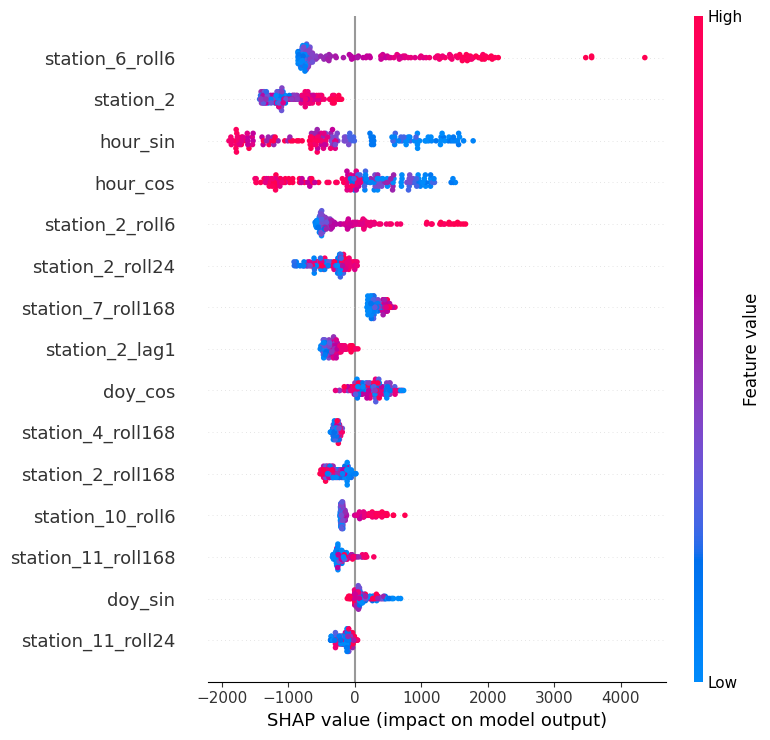

In [45]:
# Apply SHAP for interpretability
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test) # compute SHAP values for the test set  
shap.summary_plot(shap_values, X_test, max_display=15)          
# The summary plot shows the top 15 features ranked by their average absolute SHAP value (importance) across all test samples.  
# Each point represents a SHAP value for a feature and a specific test instance, colored by the feature value (red=high, blue=low).
# It visualizes both the magnitude and direction of each feature's impact on the model output.


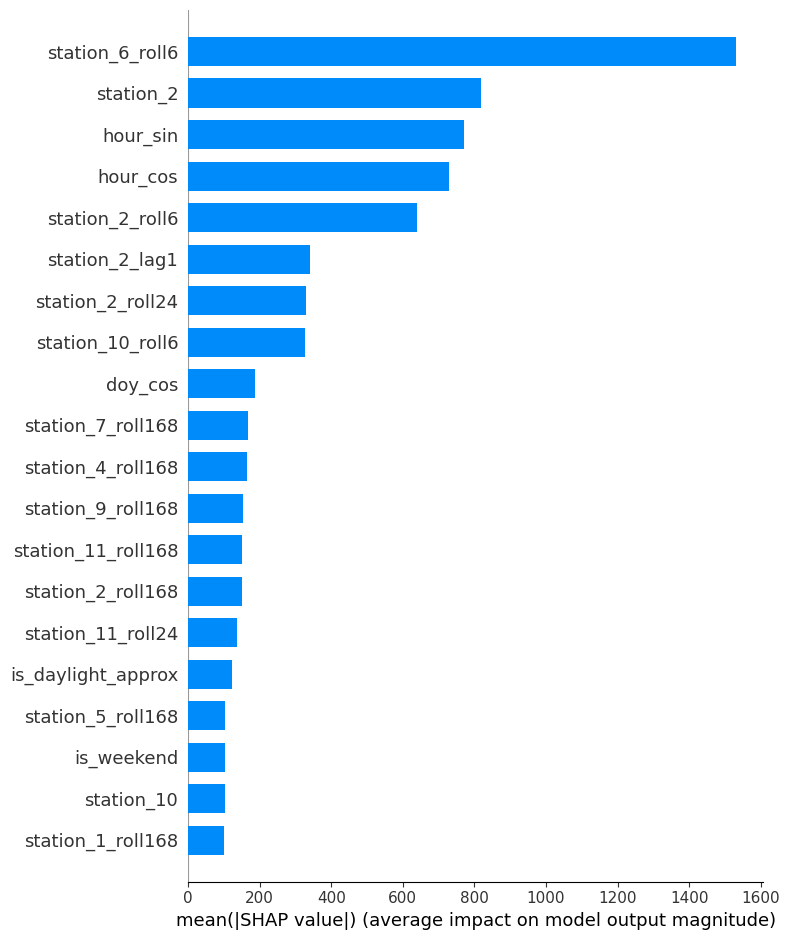

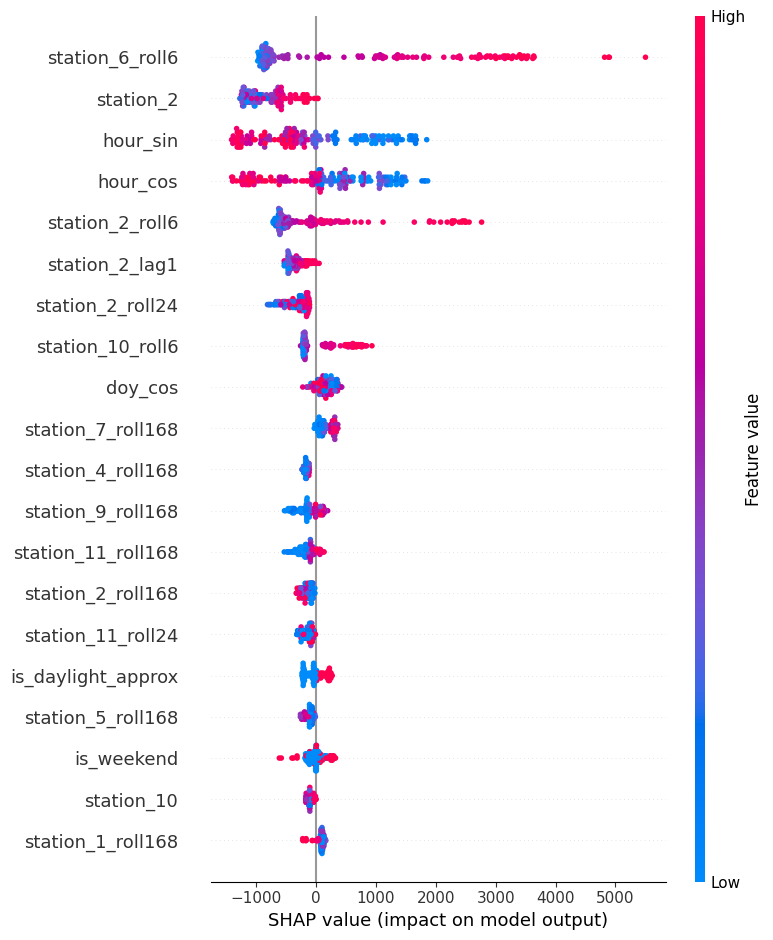

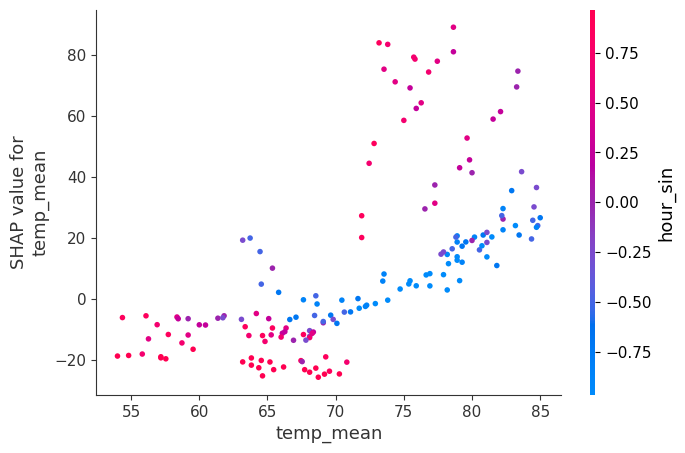

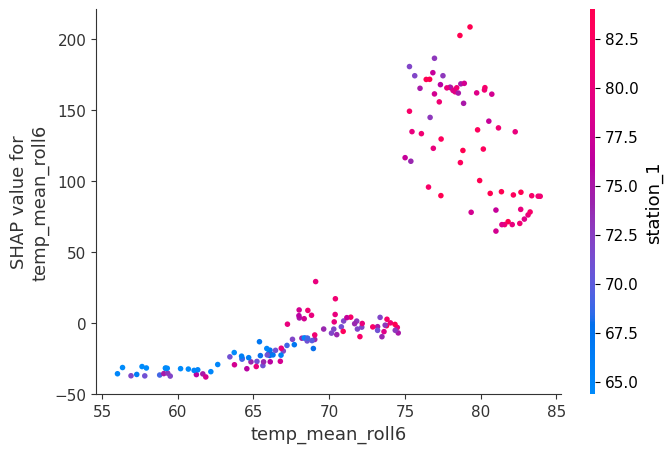

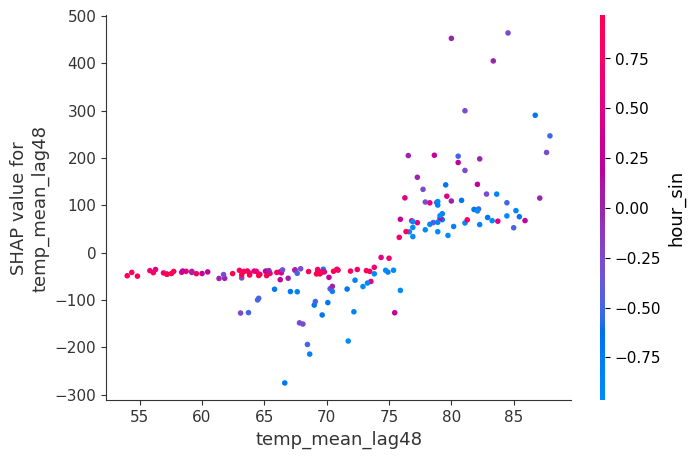

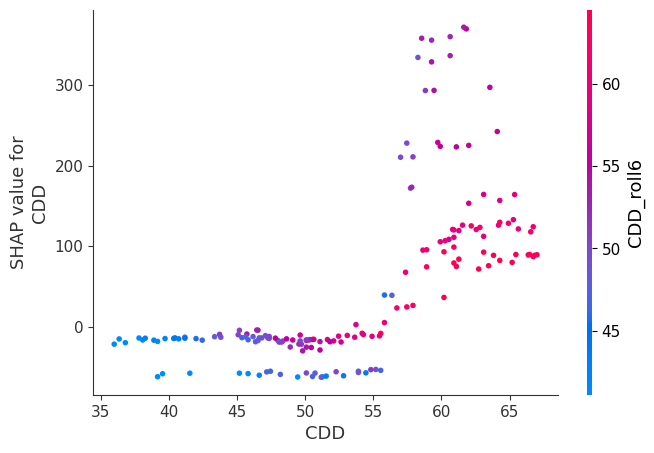

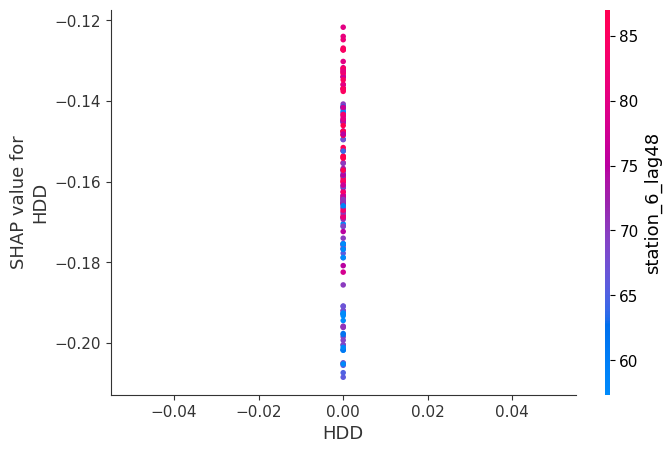

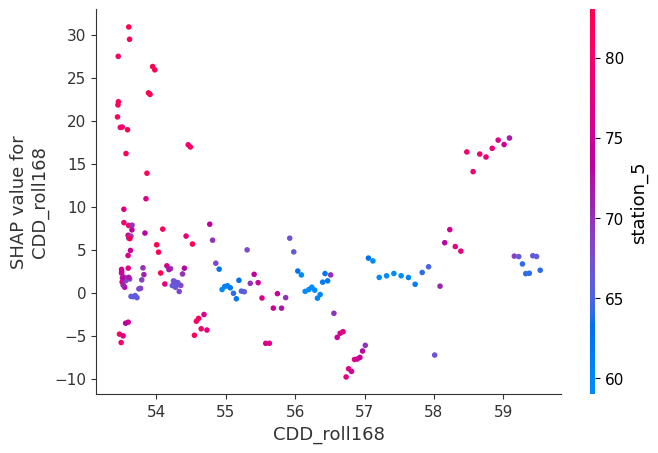

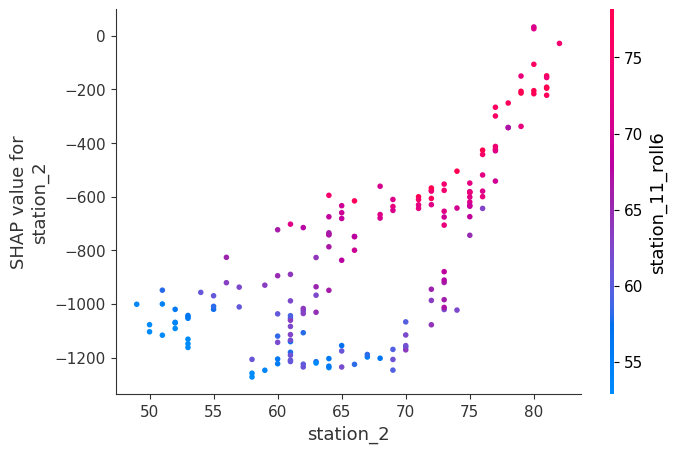

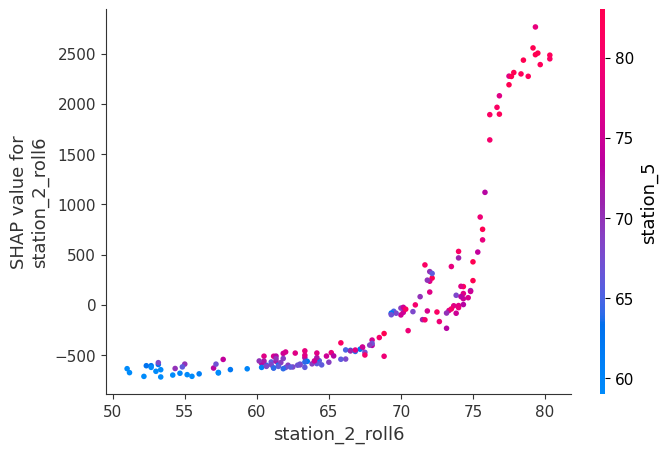

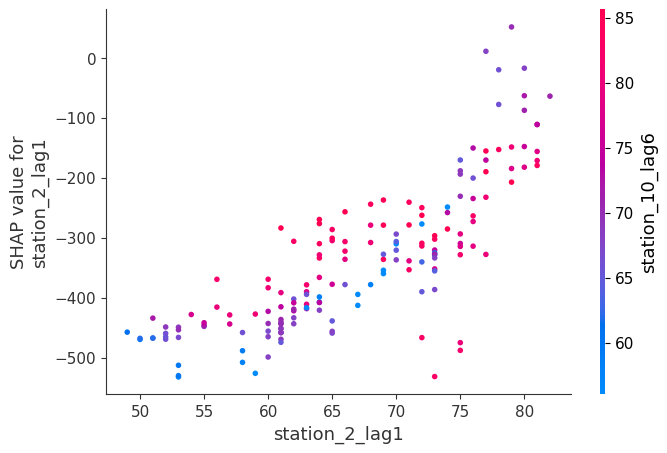

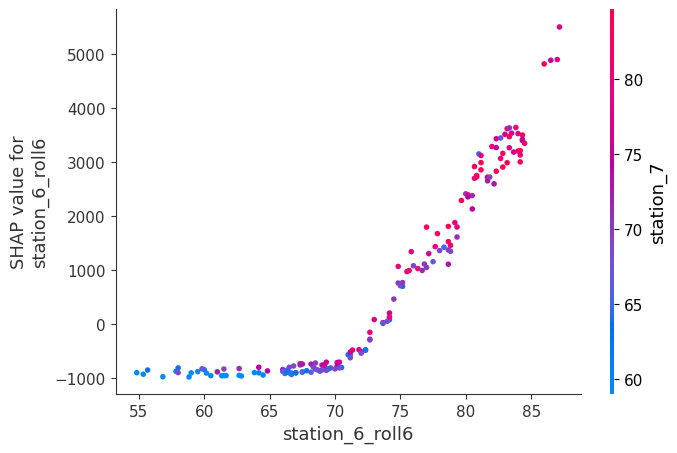

In [ ]:
# === SHAP on your XGBoost forecaster ===

# 1) Choose the slice you want to explain (use test/holdout to avoid leakage)
X_shap = X_test.copy()

# (Optional) Sample for speed if the set is huge
MAX_EXPLAIN = 8000
if len(X_shap) > MAX_EXPLAIN:
    X_shap = X_shap.sample(MAX_EXPLAIN, random_state=42).sort_index()

# 2) Build the explainer (TreeExplainer is optimized for XGBoost)
explainer = shap.TreeExplainer(xgb)

# Handle SHAP API differences across versions
try:
    sv = explainer(X_shap)          # shap>=0.40 → returns Explanation
    shap_values = sv.values
except Exception:
    shap_values = explainer.shap_values(X_shap)   # older shap
    sv = None

# 3) Global feature importance (mean |SHAP|)
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=True)

# 4) Beeswarm: distribution of impacts per feature
shap.summary_plot(shap_values, X_shap, show=True)

# 5) Targeted dependence plots for key drivers
# pick a few likely-important features that exist in your frame
candidates = [
    # temperature/rolls/lags
    "temp_mean", "temp_mean_roll6", "temp_mean_lag48",
    "CDD", "HDD", "CDD_roll168",
    # station temps
    "station_2", "station_2_roll6", "station_2_lag1",
    "station_6_roll6", "station_10_roll6",
    # calendar cycles
    "hour_sin", "hour_cos", "doy_sin", "doy_cos",
    "is_daylight_approx", "is_holiday"
]
feat_list = [c for c in candidates if c in X_shap.columns]

# (nice interaction pairs for cyclic encodings)
def _pair(f):
    if f == "hour_sin" and "hour_cos" in X_shap.columns: return "hour_cos"
    if f == "hour_cos" and "hour_sin" in X_shap.columns: return "hour_sin"
    if f == "doy_sin"  and "doy_cos"  in X_shap.columns: return "doy_cos"
    if f == "doy_cos"  and "doy_sin"  in X_shap.columns: return "doy_sin"
    return "auto"

for f in feat_list[:10]:  # keep it concise
    try:
        shap.dependence_plot(
            f, shap_values, X_shap,
            interaction_index=_pair(f),
            show=True
        )
    except Exception as e:
        print(f"[warn] dependence plot for {f} skipped: {e}")



In [ ]:
# 6) Save plots to files instead of interactive display

plt.figure(); shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False); plt.savefig("shap_importance_bar.png", dpi=160, bbox_inches="tight")
plt.figure(); shap.summary_plot(shap_values, X_shap, show=False); plt.savefig("shap_beeswarm.png", dpi=160, bbox_inches="tight")